In [335]:
import pandas as pd
import requests
import numpy as np
import unidecode
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from pathlib import Path
import json
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score

# Part 0: A class to handle GraphQL queries

In [336]:

class GraphqlQuery:
    def __init__(self, contents : dict[str : list[str]], url : str):
        self._contents = {}
        self.add(contents)
        self.url = url
    
    #method to add further tables and/or columns to the current query
    def add(self, new_contents : dict[str : list[str]]):
        
        #validate passed arguments
        if not isinstance(new_contents, dict):
            raise ValueError("Contents must be passed as dictionary")
        
        for key, val in new_contents.items() :
            if not isinstance(key, str):
                raise ValueError("Table arguments must be passed as strings")
            if not isinstance(val, list):
                raise ValueError("Set of columns must be a list")
            if not all(isinstance(column, str) for column in val):
                raise ValueError("Column arguments must be passed as strings")
            
        for table, columns in new_contents.items():
            if table not in self._contents:
                self._contents[table] = columns
            else:
                self._contents[table].extend(columns)

    #property to store current contents od query in dict format
    @property
    def contents(self):
        return self._contents
    
    #property to store finished query in graphql format
    @property
    def query(self):
        query_str =  ["query Myquery {"]
        for index, (table, columns) in enumerate(self._contents.items()):
            subquery = []
            subquery.append(table)
            subquery.append('{')
            subquery.extend(columns)
            query_str.extend(subquery)
            if index != 0: query_str +="}"
        query_str +="}}"
        
        return " ".join(query_str)
    
    def __str__(self):
        return self._query
     
    @classmethod
    def select(cls, contents : dict[str : list[str]]):
        return cls(contents)

    #method to perform get request to graphql api
    def get_data(self):
        body = {"query" : self.query}
        try:
            response = requests.post(self.url, json=body,timeout=180)
            response.raise_for_status()
            data = response.json()
            return pd.json_normalize(data['data'][list(self._contents)[0]])
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            with open("bad_response_snippet.txt", "w", encoding="utf-8") as f:
                f.write(response.text)
            print("Saved response to bad_response_snippet.txt")
        except Exception as e:
                print(f"Error fetching data: {e}")


# Part 1: Wrangling of Data

In this section the graphql API for NBA statistics is queried for player and team information via GraphqlQuery class. Additional data manipulation steps include:  
- Elimination of unwanted characters and conversion of string formats in player names (e.g. change "ć" to "c") in order to avoid problems with merges.
- Mapping of team abbreviations as these are not consistent in the API tables *teams* and *playerPerGame*.
- Merging of both tables into one comprehensive dataframe containing all necessary information.

***As of 20.10.2025, the GraphQL API stopped working. We are therefore forced to substitute the data therein by a flatfile, which was also downloaded from Kaggle.***

In [337]:
# url = 'https://nbaapi.com/graphql/'

# #set down tables and columns to query from nbaapi
# query_teams = {
#     'team' :
#     ['teamName','teamAbbr', 'season', 'wins']
#     }

# query_players = {
#     'playerPerGame' : 
#     ['playerName', 'team', 'age', 'season', 'games', 'minutesPg', 'points', 'ftPercent', 'assists', 'totalRb', 'steals', 'turnovers', 'blocks']
#     }

# #define Graphqlquery objects
# player_data = GraphqlQuery(query_players, url)
# team_data = GraphqlQuery(query_teams, url)

# #get data from the api and store it in respective dataframes
# player_stats = player_data.get_data()
# team_stats = team_data.get_data()

# #replace "*" and handle string format of player names
# team_stats.teamName = team_stats.teamName.str.replace('*', '')

# player_stats.playerName = player_stats.playerName.str.replace('*', '')
# player_stats.playerName = player_stats.playerName.apply(unidecode.unidecode)

# player_stats = player_stats[player_stats.team != 'TOT']

# #set down team abbreviations that need to be changed
# team_names = {
#     'BRK' : 'NJN',
#     'NOP' : 'NOH',
#     'CHO' : 'CHA',
#     'SEA' : 'OKC',
#     'NOK' : 'CHA',
#     'CHH' : 'CHA',
#     'VAN' : 'MEM',
#     'WSB' : 'WAS'
# }
# player_stats = player_stats.replace({'team' : team_names})

# #merge player and team statistics into one dataframe
# player_stats = player_stats.merge(
#     team_stats,
#     how='inner',
#     left_on=['season', 'team'],
#     right_on=['season', 'teamAbbr']
# ).drop(['teamAbbr'], axis=1)

# player_stats.head()

In [338]:
cols = ['Player', 'Year', 'Age', 'Team', 'G', 'MP',
       'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS']
player_stats = pd.read_csv("NBA Player Stats and Salaries_2000-2025.csv", usecols=cols)

#rename columns to match column names of dataframe extracted from GraphQL API, in preparation for merges in next cell
player_stats = player_stats.rename(
    columns={'Player': 'playerName', 'Year' : 'season', 'Team' : 'team'}
)

player_stats.head()

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
0,Shaquille O'Neal,2000,27,LAL,79,40.0,0.574,0.000,0.575,0.574,0.524,13.6,3.8,0.5,3.0,2.8,3.2,29.7
1,Kevin Garnett,2000,23,MIN,81,40.0,0.497,0.370,0.504,0.507,0.765,11.8,5.0,1.5,1.6,3.3,2.5,22.9
2,Alonzo Mourning,2000,29,MIA,79,34.8,0.551,0.000,0.553,0.551,0.711,9.5,1.6,0.5,3.7,2.7,3.9,21.7
3,Juwan Howard,2000,26,WAS,82,35.5,0.459,0.000,0.462,0.459,0.735,5.7,3.0,0.8,0.3,2.7,3.6,14.9
4,Scottie Pippen,2000,34,POR,82,33.5,0.451,0.327,0.506,0.501,0.717,6.3,5.0,1.4,0.5,2.5,2.5,12.5


In this section the above defined *player_stats* is further enhanced with the MVP and All Star selection data. Therefore, once again, the files are read and brought into the same format as the *player_stats* dataframe. Lastly, the data types in the dataframe are adjusted in preparation for model fitting. The end result is a comprehensive dataframe with all necessary information. 

In [339]:
#read mvp data and perform data clean up
current_folder = Path.cwd()

mvp_files = [f for f in current_folder.glob("*.csv") if "MVP Data" in f.name]

mvps = pd.concat(
    [pd.read_csv(file, sep=',', usecols=['Rank', 'Player', 'year', 'Tm'])
     for file in mvp_files]
)

mvps = mvps[(~mvps['Rank'].str.contains('T')) & mvps.Rank == 1]
mvps.Player = mvps.Player.apply(unidecode.unidecode)

#add data to our main dataframe
player_stats = player_stats.merge(
    mvps,
    how='left',
    left_on=['playerName','season'],
    right_on=['Player', 'year']
).drop(['Player', 'Tm','year'], axis=1)

#fill na fields with zero to prepare for forecasts 
player_stats.Rank = player_stats.Rank.fillna(0)
#player_stats.ftPercent = player_stats.ftPercent.fillna(0)
player_stats[['FG%', '3P%', '2P%', 'eFG%', 'FT%']] = player_stats[['FG%', '3P%', '2P%', 'eFG%', 'FT%']].fillna(0)


#read all start data and again perform clean up
df_allstar = pd.read_csv('1980-2022_AllStar_Data.csv',
    sep=',',
    usecols=['first', 'last', 'team', 'year']
)

df_allstar['PlayerName'] = df_allstar['first'].astype(str) + ' ' + df_allstar['last'].astype(str)

#make seasons match
df_allstar['year'] = df_allstar['year'] + 1
df_allstar = df_allstar[['PlayerName', 'team', 'year']]
#mark players that made the All Star Team in preparation for forecast
df_allstar['AllStar'] = 1
df_allstar = df_allstar.replace({'team' : team_names})

#add data to main dataframe
player_stats = player_stats.merge(
    df_allstar,
    how='outer',
    left_on=['playerName','season', 'team'],
    right_on=['PlayerName', 'year', 'team']
).drop(['PlayerName','year'], axis=1)

player_stats = player_stats[~player_stats.season.isna()]
player_stats.AllStar = player_stats.AllStar.fillna(0)

#change column variable due to malfunction in GraphQL API
columns = ['season', 'Age', 'G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Rank']
# columns = ['points', 'assists', 'turnovers', 'games', 'ftPercent', 'blocks', 'totalRb', 'wins', 'Rank']
player_stats[columns] = player_stats[columns].apply(pd.to_numeric, errors='coerce')

player_stats.head()

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Rank,AllStar
0,Shaquille O'Neal,2000.0,27.0,LAL,79.0,40.0,0.574,0.000,0.575,0.574,0.524,13.6,3.8,0.5,3.0,2.8,3.2,29.7,0,1.0
1,Kevin Garnett,2000.0,23.0,MIN,81.0,40.0,0.497,0.370,0.504,0.507,0.765,11.8,5.0,1.5,1.6,3.3,2.5,22.9,0,1.0
2,Alonzo Mourning,2000.0,29.0,MIA,79.0,34.8,0.551,0.000,0.553,0.551,0.711,9.5,1.6,0.5,3.7,2.7,3.9,21.7,0,1.0
3,Juwan Howard,2000.0,26.0,WAS,82.0,35.5,0.459,0.000,0.462,0.459,0.735,5.7,3.0,0.8,0.3,2.7,3.6,14.9,0,0.0
4,Scottie Pippen,2000.0,34.0,POR,82.0,33.5,0.451,0.327,0.506,0.501,0.717,6.3,5.0,1.4,0.5,2.5,2.5,12.5,0,0.0


In [340]:
player_stats.describe().drop(columns=['season', 'AllStar'])

,Age,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Rank
count,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000
mean,26.468333,53.277852,20.967570,0.443931,0.261866,0.481261,0.490870,0.713861,3.728548,1.955933,0.660177,0.432011,1.198378,1.832650,8.786389,0.149466
std,4.299332,23.881280,9.731078,0.093928,0.165770,0.107309,0.095774,0.183957,2.470164,1.861626,0.431298,0.466723,0.812211,0.781999,6.207002,1.113547
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,36.000000,13.000000,0.404000,0.147750,0.439750,0.455000,0.664000,1.900000,0.700000,0.300000,0.100000,0.600000,1.300000,4.000000,0.000000
50%,26.000000,60.000000,20.700000,0.442000,0.320000,0.483000,0.497000,0.754000,3.200000,1.300000,0.600000,0.300000,1.000000,1.800000,7.300000,0.000000
75%,29.000000,74.000000,29.100000,0.486000,0.371000,0.532000,0.537000,0.821000,4.900000,2.600000,0.900000,0.600000,1.600000,2.400000,12.100000,0.000000
max,43.000000,85.000000,43.700000,1.000000,1.000000,1.000000,1.500000,1.000000,16.000000,11.700000,3.000000,3.800000,5.700000,5.000000,36.100000,17.000000


In [341]:
player_stats.corr(numeric_only=True).loc[columns, ['AllStar', 'Rank']]

,AllStar,Rank
season,-0.065384,-0.044104
Age,0.043538,0.032919
G,0.180217,0.110332
MP,0.341783,0.202089
FG%,0.091105,0.052044
3P%,0.063733,0.045075
2P%,0.062964,0.035336
eFG%,0.068196,0.038581
FT%,0.099206,0.061769
TRB,0.319058,0.175334


<Axes: xlabel='AllStar', ylabel='PTS'>

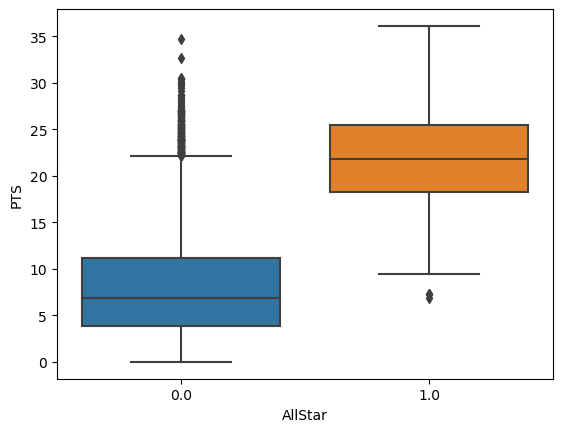

In [342]:
sns.boxplot(data=player_stats, x="AllStar", y="PTS")

In [343]:
df_train = player_stats[player_stats.season.between(2000, 2015)]
df_test = player_stats[player_stats.season.between(2015, 2023)]

In [344]:
X = df_train[columns]
y_mvp = df_train.Rank.astype('int')
y_allstar = df_train.AllStar.astype('int')

model_xgb_mvp = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# fit model
model_xgb_mvp.fit(X, y_mvp)

model_xgb_allstar = XGBClassifier()
model_xgb_allstar.fit(X, y_allstar)

#Train Logistic Regression classifier
model_log_mvp = LogisticRegression(solver='liblinear', C=1.0).fit(X, y_mvp)
model_log_allstar = LogisticRegression(solver='liblinear', C=1.0).fit(X, y_allstar)

# Train Decision Tree Classifer
model_clf_mvp = DecisionTreeClassifier().fit(X,y_mvp)
model_clf_allstar = DecisionTreeClassifier().fit(X,y_allstar)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
#scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores = absolute(scores)

# y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)

<Axes: >

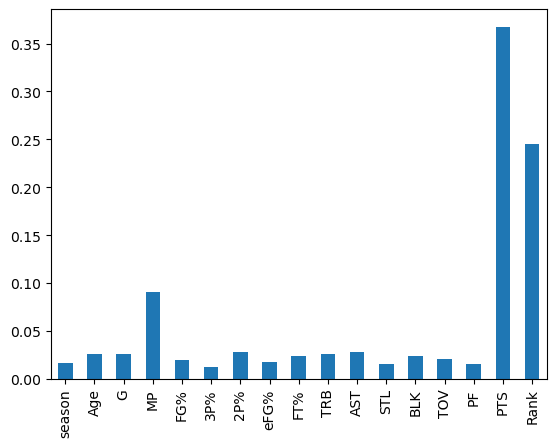

In [355]:
pd.Series(model_xgb_allstar.feature_importances_, X.columns).plot(kind='bar')

<Axes: >

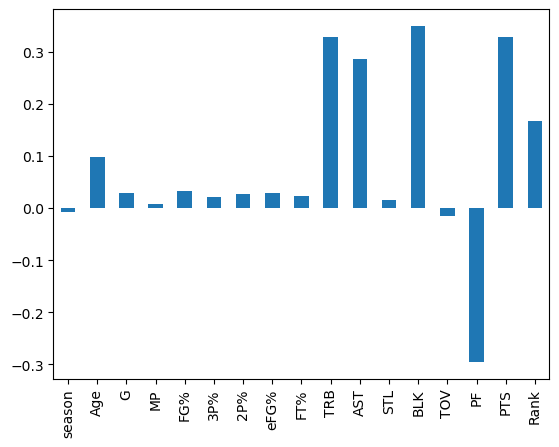

In [356]:
pd.Series(model_log_allstar.coef_[0], X.columns).plot(kind='bar')

In [358]:
cross_val_score(model_xgb_allstar, X, y_allstar, scoring='f1', cv=5).mean()

0.6127692973445991

In [348]:
df_score = df_test.copy()
df_score = df_score[df_score.season < 2024]

df_score['Log_Prediction'] = model_xgb_allstar.predict(df_score[columns])
df_score['XGB_Prediction'] = model_log_allstar.predict(df_score[columns])
df_score['Tree_Prediction'] = model_clf_allstar.predict(df_score[columns])

f1 = (
    df_score.groupby('season')
    .apply(lambda x: pd.Series({
        'F1_Log': f1_score(x['AllStar'], x['Log_Prediction']),
        'F1_XGB': f1_score(x['AllStar'], x['XGB_Prediction']),
        'F1_Tree': f1_score(x['AllStar'], x['Tree_Prediction'])
    }))
    .reset_index()
)

auc = (
    df_score.groupby('season')
    .apply(lambda x: pd.Series({
        'AUC_Log': roc_auc_score(x['AllStar'], x['Log_Prediction']),
        'AUC_XGB': roc_auc_score(x['AllStar'], x['XGB_Prediction']),
        'AUC_Tree': roc_auc_score(x['AllStar'], x['Tree_Prediction'])
    }))
    .reset_index()
)

In [ ]:
def score_evolution_plot(df_data, column_list, label):

    x_axis = df_data.season

    fig = go.Figure(data=[
    go.Bar(name='Log Regression', x=x_axis, y=df_data[column_list[0]], marker_color='green'),
    go.Bar(name='XGB Classifier', x=x_axis, y=df_data[column_list[1]], marker_color='chocolate'),
    go.Bar(name='Decision Tree', x=x_axis, y=df_data[column_list[2]], marker_color='blue')
    
    ])

    fig.update_layout(
        barmode='group',
        title=label
    )
    
    fig.show()

In [350]:
score_evolution_plot(f1, ['F1_Log', 'F1_XGB', 'F1_Tree'], 'F1 Score Evolution')
score_evolution_plot(auc, ['AUC_Log', 'AUC_XGB', 'AUC_Tree'], 'AUC Score Evolution')

In [351]:
# df = df_test[columns].copy()
df = df_test.copy()

df['Log_Prediction'] = model_xgb_allstar.predict_proba(df[columns])[:,1]
df['XGB_Prediction'] = model_log_allstar.predict_proba(df[columns])[:,1]
df['Tree_Prediction'] = model_clf_allstar.predict_proba(df[columns])[:,1]

df_long = df.melt(
    id_vars = ['season', 'playerName', 'AllStar'],
    value_vars = ['Log_Prediction', 'XGB_Prediction', 'Tree_Prediction'],
    var_name='Model',
    value_name='Prediction'
)

top_preds = (
    df_long
        .sort_values(by=['season', 'Model', 'Prediction'], ascending=[True, True, False])
        .groupby(by=['season', 'Model'])
        .head(24)
)

allstars = df_test.groupby(by='season')['AllStar'].sum()

correct = (
    top_preds
        .groupby(by=['season', 'Model'])['AllStar'].sum()
        .reset_index(name="Correct")
        .merge(allstars, on="season")
        .assign(pct=lambda x : x.Correct / x.AllStar)
        .pivot(index='season', columns='Model', values='pct')
        .reset_index()
)

correct

Model,season,Log_Prediction,Tree_Prediction,XGB_Prediction
0,2015.0,1.000000,1.000000,0.652174
1,2016.0,0.782609,0.521739,0.782609
2,2017.0,0.700000,0.550000,0.750000
3,2018.0,0.684211,0.526316,0.736842
4,2019.0,0.652174,0.608696,0.739130
5,2020.0,0.652174,0.347826,0.695652
6,2021.0,0.666667,0.611111,0.777778
7,2022.0,0.772727,0.454545,0.636364
8,2023.0,0.666667,0.428571,0.809524


In [352]:
score_evolution_plot(correct, ['Log_Prediction', 'XGB_Prediction', 'Tree_Prediction'], 'Accuracy Score Evolution')